<a href="https://colab.research.google.com/github/Manan-Parakh/CBTCIP-/blob/main/IRIS/Iris_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [248]:
# General Libraries
import pandas as pd
import numpy as np
import os
import sys
import sklearn
import pickle

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# To Store the pretty images we create
ROOT = "."
PROJECT_NAME = "IRIS_FLOWER_CLASSIFICATION"
IMAGES_PATH = os.path.join(ROOT, PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(figname, extension = "png", resolution = 300, tight_layout = True):
  path = os.path.join(IMAGES_PATH, figname + '.' + extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format = extension, dpi = 300)

# Dataset

In [33]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [38]:
X = iris.data
y = iris.target.astype(int)

In [35]:
target_names = iris.target_names
feature_names = iris.feature_names
target_names, feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [36]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Exploratory Data Analysis

In [6]:
# Statistical Information
X.columns = feature_names
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
# Exploring the DataTypes and null values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


The Dataset is already clean and well tuned to the needs of a ML algorithm.

# Data Visualization

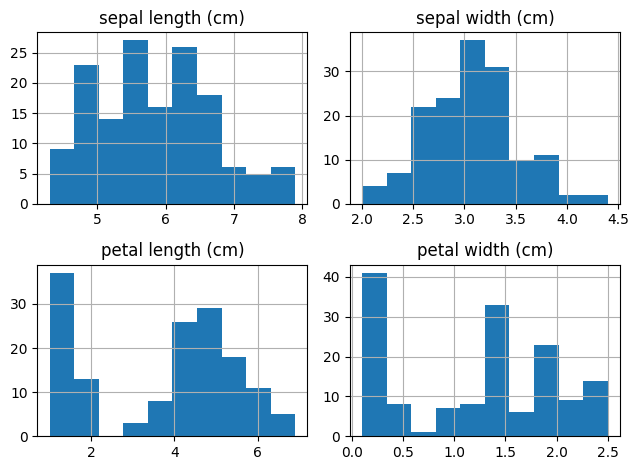

In [ ]:
X.hist()
save_fig('Distribution of Features')

In [ ]:
columns = ["sl", "sw", "pl", "pw", "target"]

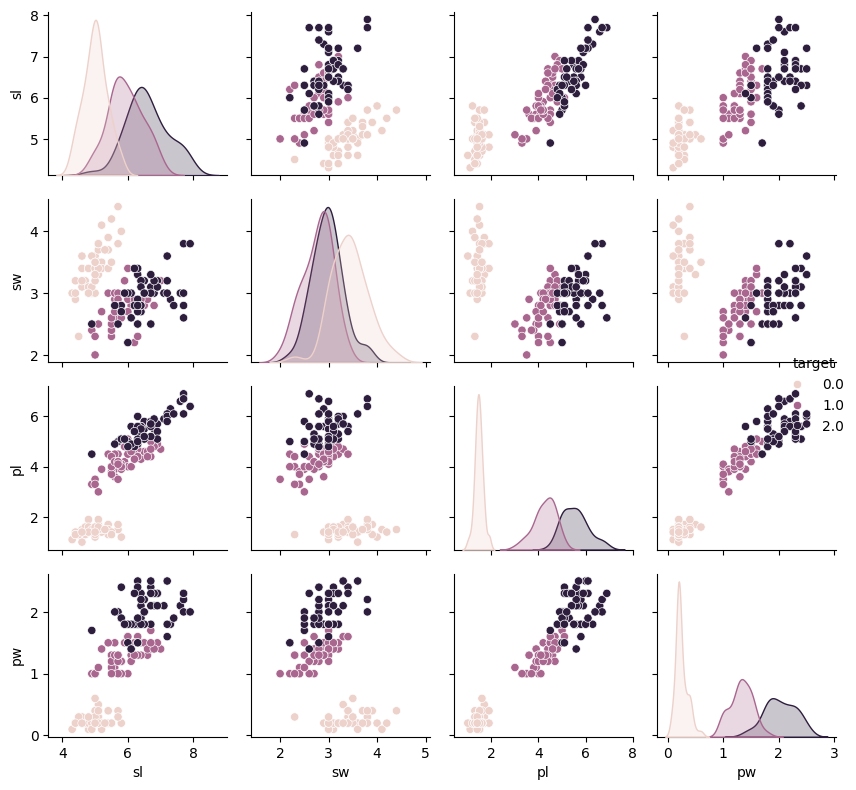

In [ ]:
sns.pairplot(pd.DataFrame(np.c_[X,y], columns = columns), hue = 'target', height = 2)
save_fig('PairPlot of Features')

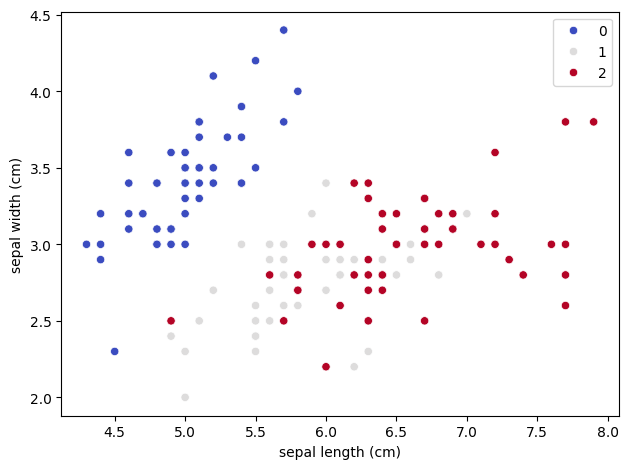

In [ ]:
# Let's view a particular chart
sns.scatterplot(x = X['sepal length (cm)'], y = X['sepal width (cm)'], hue = iris.target, palette = "coolwarm")
save_fig('sepal_width vs sepal_length')

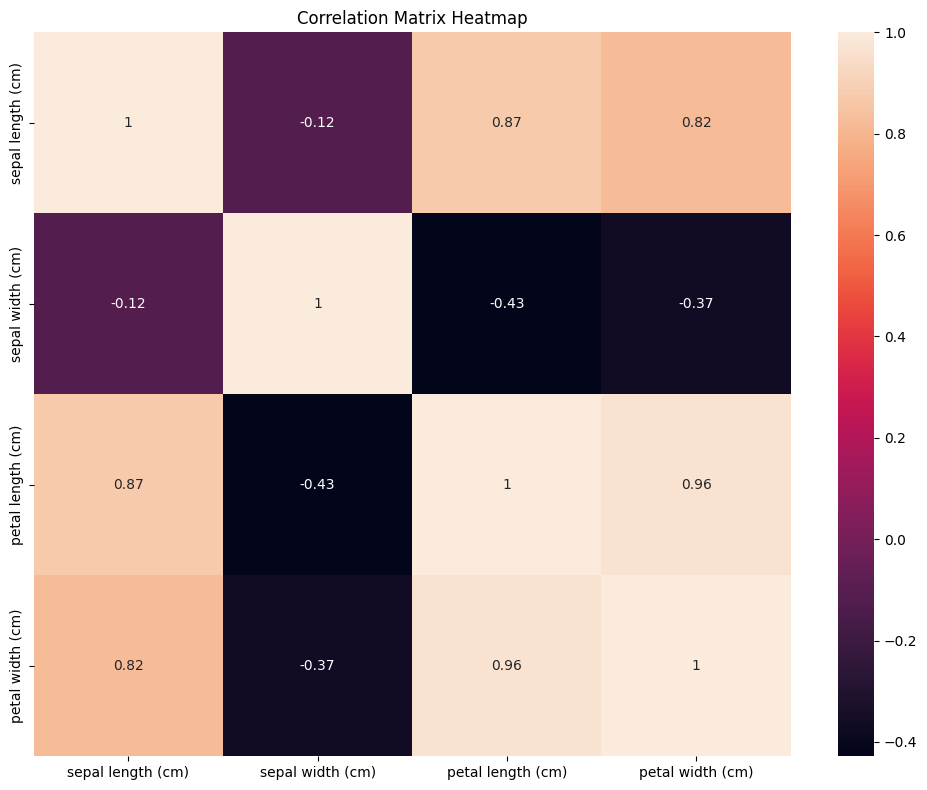

In [ ]:
# Correlation Matrix
corr_mat = X.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_mat, annot = True)
plt.title("Correlation Matrix Heatmap")
save_fig('Features Correlation Matrix Heatmap')

# Create the Test Set

In [39]:
# Split the dataset
# To ensure proper representation of all classes in the test and train set, we use StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.3, random_state = 42)
for train_index, test_index in split.split(X,y):
  X_train = X[train_index]
  X_test = X[test_index]
  y_train = y[train_index].flatten()
  y_test = y[test_index].flatten()

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((105, 4), (105,), (45, 4), (45,))

In [242]:
pd.Series(y_train).value_counts()/len(y_train)

1    0.333333
0    0.333333
2    0.333333
Name: count, dtype: float64

In [244]:
pd.Series(y_test).value_counts()/len(y_test)

2    0.333333
1    0.333333
0    0.333333
Name: count, dtype: float64

# Custom Functions

In [245]:
# After a lot of runs, it is getting hectic to calculate various metrics again and again,
# Lets create a function
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def model_perf(model, title, figsave = True):
  """ Take the model,
  1. Fit the training data,
  2. Get the metrics on trained data and test data
  3. Metrics to get -> Accuracy, Precision, Recall and F1_score, Plot the Confusion Matrix, AUC and ROC curve
  title -> Title and Name of the plot
  figsave -> Setting it to False prevents the function from saving the figure while tuning hyperparameters
  """
  X_tr = X_train.copy()
  X_te = X_test.copy()
  y_tr = y_train.copy()
  y_te = y_test.copy()

  model.fit(X_tr, y_tr)
  y_pred_tr = model.predict(X_tr)
  y_pred_te = model.predict(X_te)

  # Accuracy
  accuracy_tr = cross_val_score(model, X_tr, y_tr, cv=5)
  print("Accuracy Score on Training Set:", accuracy_tr, "mean:", accuracy_tr.mean())

  # Classification_report
  cr_tr = pd.DataFrame(classification_report(y_tr, y_pred_tr, output_dict = True)).T
  cr_te = pd.DataFrame(classification_report(y_te, y_pred_te, output_dict = True)).T

  print('Train Report')
  print(cr_tr)

  print('Test Report')
  print(cr_te)

  # Plot the Heatmaps of Confusion matrix
  conf_mat_tr = confusion_matrix(y_tr, y_pred_tr)
  conf_mat_te = confusion_matrix(y_te, y_pred_te)
  fig, axes = plt.subplots(1,2, figsize = (10,5))
  plt.suptitle(title, fontsize = 16)
  sns.heatmap(conf_mat_tr, ax = axes[0], annot = True)
  sns.heatmap(conf_mat_te, ax = axes[1], annot = True)
  axes[0].set_title('Train Set')
  axes[1].set_title('Test Set')
  axes[0].set_xlabel('Predicted Class')
  axes[0].set_ylabel('Actual Class')
  axes[1].set_xlabel('Predicted Class')
  if figsave:
    save_fig(title)

# Random Forest Classifier

In [230]:
# import pickle
# Commenting this so that it does not get executed in complete run
# with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf.pkl", mode = 'rb') as file:
#   rnd_clf = pickle.load(file)

Accuracy Score on Training Set: [0.95238095 0.95238095 1.         0.9047619  0.95238095] mean: 0.9523809523809523
Train Report
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     35.0
1                   1.0     1.0       1.0     35.0
2                   1.0     1.0       1.0     35.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    105.0
weighted avg        1.0     1.0       1.0    105.0
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.777778  0.933333  0.848485  15.000000
2              0.916667  0.733333  0.814815  15.000000
accuracy       0.888889  0.888889  0.888889   0.888889
macro avg      0.898148  0.888889  0.887767  45.000000
weighted avg   0.898148  0.888889  0.887767  45.000000


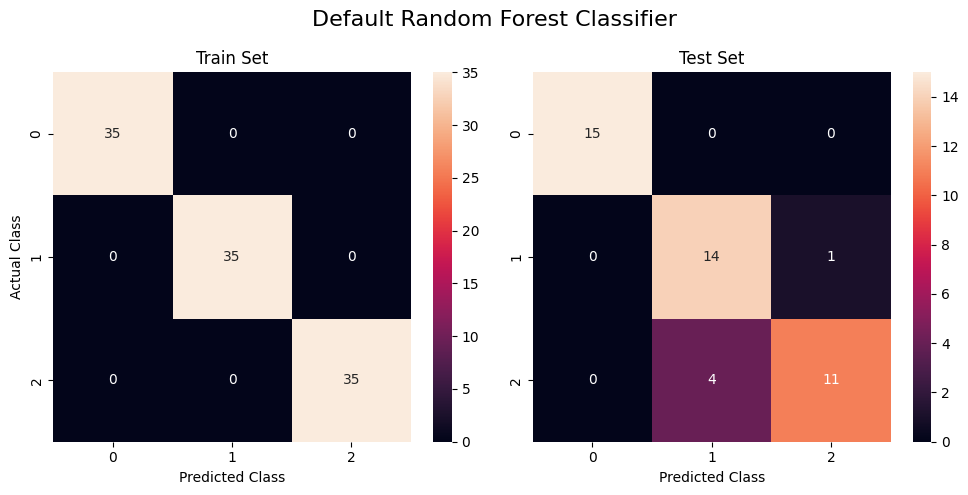

In [231]:
# Evaluate the performance of a RFC
from sklearn.ensemble import RandomForestClassifier
model_perf(RandomForestClassifier(), "Default Random Forest Classifier")

Default RFC overfits. So we will now try to regularize the model.
1. Reduce the number of estimators.
2. Reduce the max_depth.
3. Increase the min_samples_split.
Will do these one by one and then try to find the best combination.

In [176]:
# We will use GridSearchCV to figure out the best possible parameters for our RandomForestClassifier
parameter_grid = [
    {"n_estimators": [50, 75, 80, 100]},
    {"max_depth": range(1,5)},
    {'min_samples_split': range(2,10)}
]
grid = GridSearchCV(RandomForestClassifier(), parameter_grid, cv = 3)
grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': 75}

In [177]:
# After finding out the best values of the three, let's experiment by putting all together
rnd_clf = RandomForestClassifier(max_depth = 1, min_samples_split = 4, n_estimators = 75)

Accuracy Score on Training Set: [0.95238095 0.95238095 1.         0.95238095 1.        ] mean: 0.9714285714285713
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   35.000000
1              1.000000  0.942857  0.970588   35.000000
2              0.945946  1.000000  0.972222   35.000000
accuracy       0.980952  0.980952  0.980952    0.980952
macro avg      0.981982  0.980952  0.980937  105.000000
weighted avg   0.981982  0.980952  0.980937  105.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.933333  0.933333  0.933333  15.000000
2              0.933333  0.933333  0.933333  15.000000
accuracy       0.955556  0.955556  0.955556   0.955556
macro avg      0.955556  0.955556  0.955556  45.000000
weighted avg   0.955556  0.955556  0.955556  45.000000


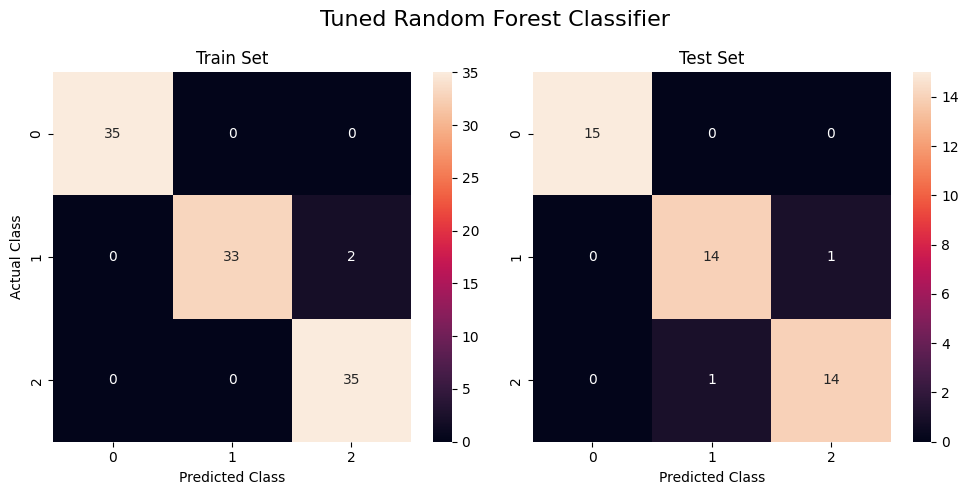

In [232]:
model_perf(rnd_clf, "Tuned Random Forest Classifier")

In [283]:
rnd_clf.feature_importances_

array([0.22666667, 0.        , 0.42666667, 0.34666667])

In [179]:
# # Let's save the model so that we don't have to train it again and again
# import pickle
# with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf.pkl", mode = 'wb') as file:
#   pickle.dump(rnd_clf, file)

## Using ExtraTreesClassifier

In [238]:
# # importing the saved model from first run
# with open("/content/drive/MyDrive/CipherByte/IRIS/extra_clf.pkl", mode = 'rb') as file:
#   extra_clf = pickle.load(file)

Accuracy Score on Training Set: [0.95238095 0.95238095 1.         0.95238095 1.        ] mean: 0.9714285714285713
Train Report
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     35.0
1                   1.0     1.0       1.0     35.0
2                   1.0     1.0       1.0     35.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    105.0
weighted avg        1.0     1.0       1.0    105.0
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.823529  0.933333  0.875000  15.000000
2              0.923077  0.800000  0.857143  15.000000
accuracy       0.911111  0.911111  0.911111   0.911111
macro avg      0.915535  0.911111  0.910714  45.000000
weighted avg   0.915535  0.911111  0.910714  45.000000


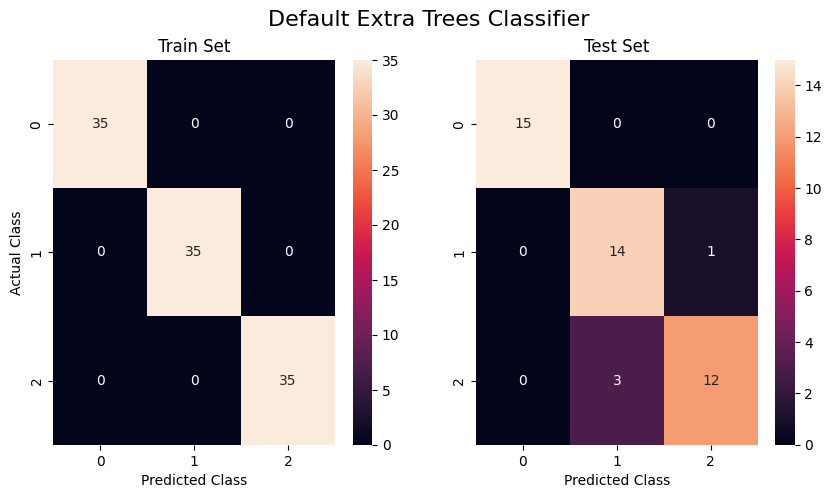

In [247]:
from sklearn.ensemble import ExtraTreesClassifier
model_perf(ExtraTreesClassifier(), "Default Extra Trees Classifier", figsave = False)

The Default Extra Trees Classifier overfits. Let's regularize it.
1. Reducing n_estimators.
2. Reducing max_depth.
3. Increasing min_samples_split.

In [257]:
params_grid_extra = [{'n_estimators': np.arange(27,40),
                     "max_depth" : range(2,5),
                     "min_samples_split": range(5,8)}]

grid_extra = GridSearchCV(ExtraTreesClassifier(), params_grid_extra, cv = 3)
grid_extra.fit(X_train, y_train)
grid_extra.best_params_

{'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 29}

In [278]:
extra_clf = ExtraTreesClassifier(min_samples_split = 6, max_depth = 2, n_estimators = 35) #f1 0.96, 0.93

Accuracy Score on Training Set: [0.95238095 0.95238095 0.95238095 0.9047619  1.        ] mean: 0.9523809523809522
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   35.000000
1              0.968750  0.885714  0.925373   35.000000
2              0.894737  0.971429  0.931507   35.000000
accuracy       0.952381  0.952381  0.952381    0.952381
macro avg      0.954496  0.952381  0.952293  105.000000
weighted avg   0.954496  0.952381  0.952293  105.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.928571  0.866667  0.896552  15.000000
2              0.875000  0.933333  0.903226  15.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.934524  0.933333  0.933259  45.000000
weighted avg   0.934524  0.933333  0.933259  45.000000


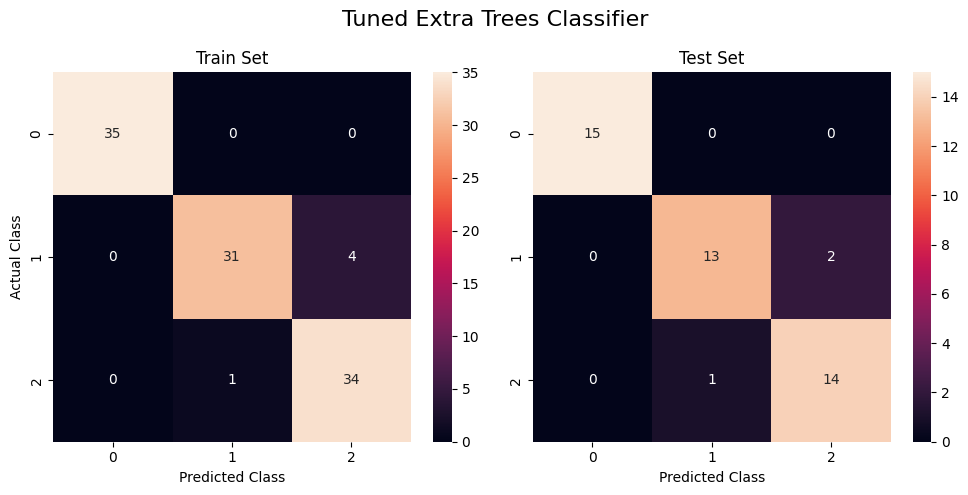

In [240]:
model_perf(extra_clf, "Tuned Extra Trees Classifier")

In [284]:
extra_clf.feature_importances_

array([0.13465922, 0.07059265, 0.31459455, 0.48015358])

In [282]:
# with open("/content/drive/MyDrive/CipherByte/IRIS/extra_clf.pkl", mode = 'wb') as file:
#   pickle.dump(extra_clf, file)

# Using AdaBoost

In [53]:
# # Importing the model from previous run
# with open("/content/drive/MyDrive/CipherByte/IRIS/ada_clf.pkl", mode = 'rb') as file:
#   ada_clf = pickle.load(file)

Accuracy Score on Training Set: [0.95238095 0.95238095 0.95238095 0.9047619  0.95238095] mean: 0.9428571428571427
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   35.000000
1              0.944444  0.971429  0.957746   35.000000
2              0.970588  0.942857  0.956522   35.000000
accuracy       0.971429  0.971429  0.971429    0.971429
macro avg      0.971678  0.971429  0.971423  105.000000
weighted avg   0.971678  0.971429  0.971423  105.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.875000  0.933333  0.903226  15.000000
2              0.928571  0.866667  0.896552  15.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.934524  0.933333  0.933259  45.000000
weighted avg   0.934524  0.933333  0.933259  45.000000


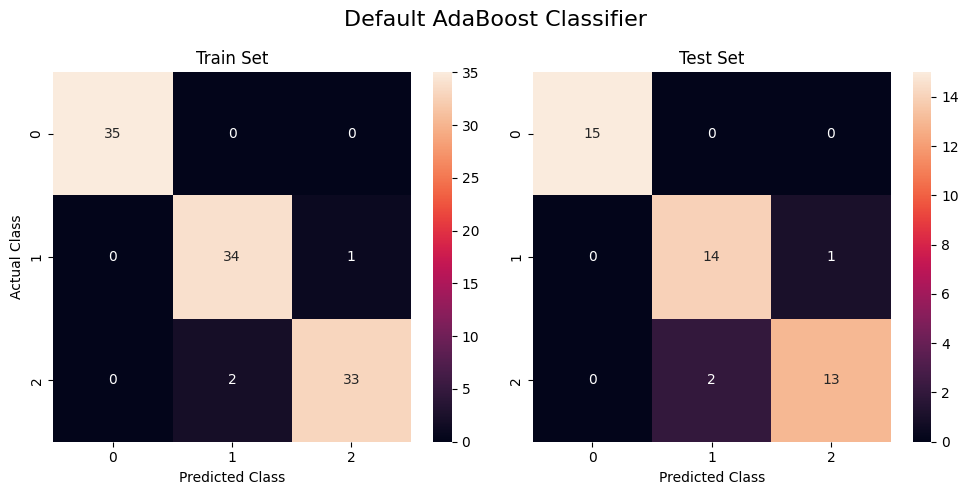

In [249]:
# Let's first evaluate the performance of Default Model
from sklearn.ensemble import AdaBoostClassifier
model_perf(AdaBoostClassifier(), "Default AdaBoost Classifier")

In [168]:
ada_clf.feature_importances_

array([0.  , 0.  , 0.56, 0.44])

The model is overfitting a bit but the results are acceptable as the cross_val_score is around 0.94 only.

In [169]:
# with open("/content/drive/MyDrive/CipherByte/IRIS/ada_clf.pkl", mode = 'wb') as file:
#   pickle.dump(ada_clf, file)

# Using Gradient Boosting

In [ ]:
# # Importing the model from previous run
# with open("/content/drive/MyDrive/CipherByte/IRIS/gbc_clf.pkl", mode = 'rb') as file:
#   gbc_clf = pickle.load(file)

Accuracy Score on Training Set: [0.95238095 0.95238095 1.         0.9047619  0.95238095] mean: 0.9523809523809523
Train Report
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     35.0
1                   1.0     1.0       1.0     35.0
2                   1.0     1.0       1.0     35.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    105.0
weighted avg        1.0     1.0       1.0    105.0
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.875000  0.933333  0.903226  15.000000
2              0.928571  0.866667  0.896552  15.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.934524  0.933333  0.933259  45.000000
weighted avg   0.934524  0.933333  0.933259  45.000000


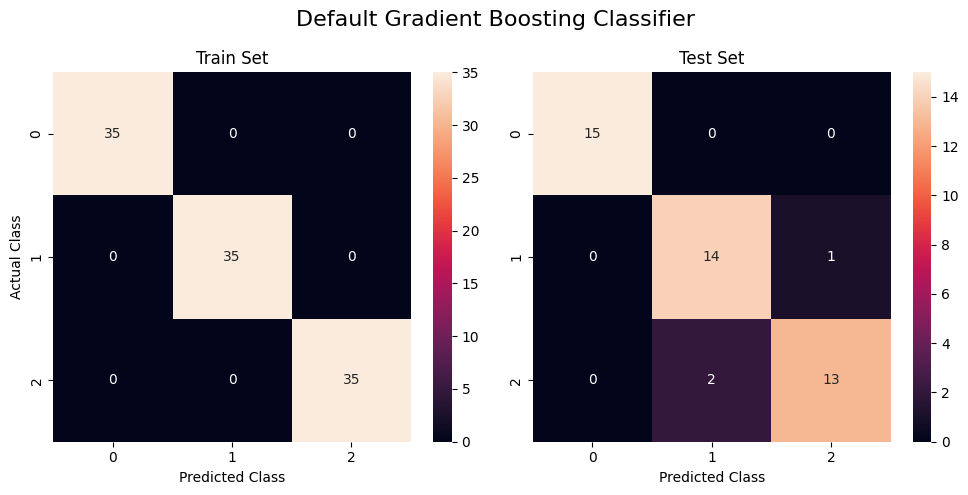

In [46]:
# Let's Evaluate the Default Tree
from sklearn.ensemble import GradientBoostingClassifier
model_perf(GradientBoostingClassifier(), "Default Gradient Boosting Classifier")

It Overfits. Let's Regularize it.
1. Reduce n_estimators. (100)
2. Reduce max_depth. (3)
3. Increase min_samples_split. (2)
4. Reduce learning_rate. (0.1)
5. We can try reducing the subsample as well. (1.0)

In [51]:
params_grid_gbc = {"n_estimators": [50, 75, 80, 90, 100],
                   "learning_rate": np.arange(0,1,0.2),
                   "max_depth": range(1,3),
                   "min_samples_split": range(2,10)}
grid_gbc = GridSearchCV(GradientBoostingClassifier(), params_grid_gbc, cv = 3)
grid_gbc.fit(X_train,y_train)
grid_gbc.best_params_

{'learning_rate': 0.2,
 'max_depth': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Accuracy Score on Training Set: [0.95238095 0.95238095 1.         0.9047619  1.        ] mean: 0.9619047619047618
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   35.000000
1              1.000000  0.942857  0.970588   35.000000
2              0.945946  1.000000  0.972222   35.000000
accuracy       0.980952  0.980952  0.980952    0.980952
macro avg      0.981982  0.980952  0.980937  105.000000
weighted avg   0.981982  0.980952  0.980937  105.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              1.000000  0.933333  0.965517  15.000000
2              0.937500  1.000000  0.967742  15.000000
accuracy       0.977778  0.977778  0.977778   0.977778
macro avg      0.979167  0.977778  0.977753  45.000000
weighted avg   0.979167  0.977778  0.977753  45.000000


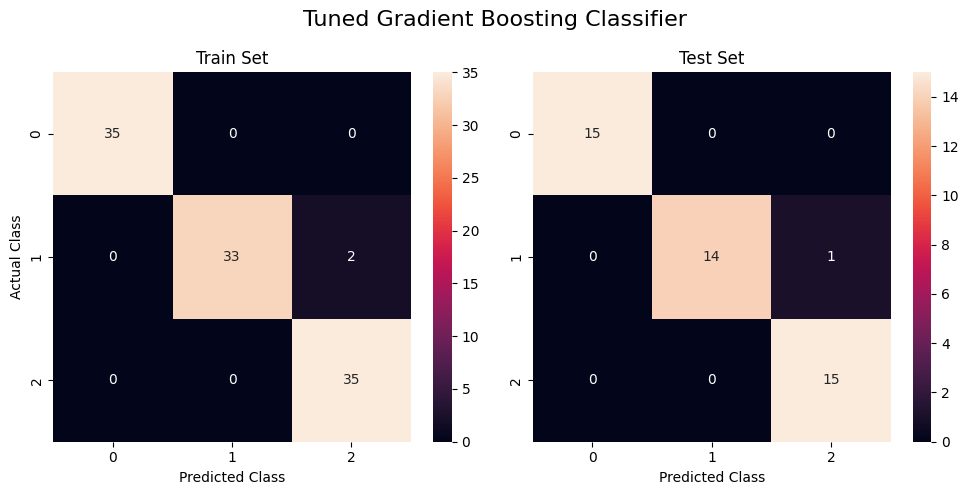

In [82]:
#After some manual shifting around the parameters provided by GridSearchCV
gbc_clf = GradientBoostingClassifier(n_estimators = 15, min_samples_split = 2, learning_rate = 0.2, max_depth = 1)
model_perf(gbc_clf, "Tuned Gradient Boosting Classifier")

In [86]:
# with open("/content/drive/MyDrive/CipherByte/IRIS/gbc_clf.pkl", mode ="wb") as file:
#   pickle.dump(gbc_clf, file)

# Using XGBoost

In [ ]:
# # load the model from previous run
# with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf.pkl", mode = 'rb') as file:
#   xgb_clf = pickle.load(file)

Accuracy Score on Training Set: [0.9047619  0.95238095 1.         0.9047619  0.95238095] mean: 0.9428571428571428
Train Report
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     35.0
1                   1.0     1.0       1.0     35.0
2                   1.0     1.0       1.0     35.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    105.0
weighted avg        1.0     1.0       1.0    105.0
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.875000  0.933333  0.903226  15.000000
2              0.928571  0.866667  0.896552  15.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.934524  0.933333  0.933259  45.000000
weighted avg   0.934524  0.933333  0.933259  45.000000


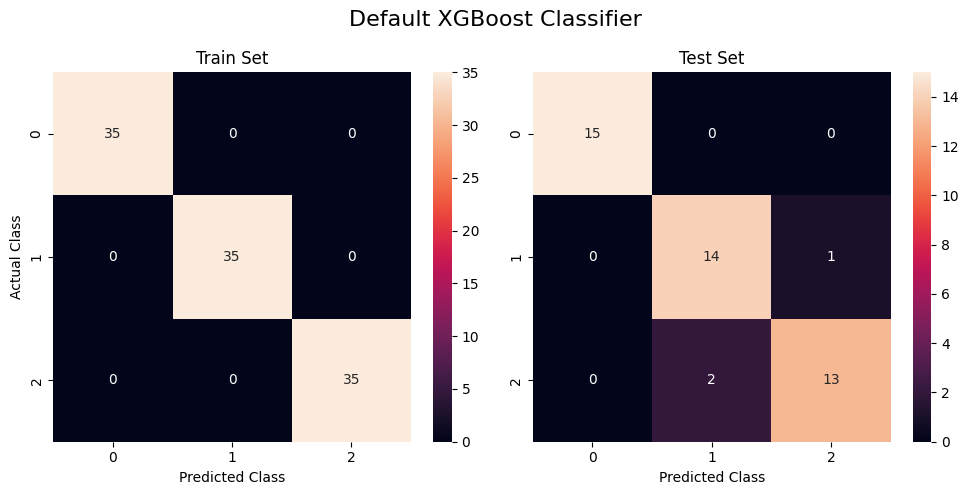

In [226]:
import xgboost
model_perf(xgboost.XGBClassifier(),"Default XGBoost Classifier")

It Overfits. let's tune the hyperparamters.
1. Reduce the max_depth
2. reduce eta to slow down learning and capture the underlying pattern in a better way.
3. Gamma: larger values helps in reducing overfitting.
4. colsample_bytrees: Introduces randomness in feature considered for splitting in each tree.
5. min_child_weight: Higher values tends to reduce the risk of overfitting.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params_grid_xgb = {
    'eta': [0.1, 0.3],
    'max_depth': range(1,5),
    'min_child_weight': range(1,4),
    'gamma': np.random.rand(100),
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
    }
grid_random_xgb = RandomizedSearchCV(xgb_clf, params_grid_xgb, n_iter = 100)
grid_random_xgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False, eta=1,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=N...
       0.75499853, 0.78746071, 0.69089005, 0.77421318, 0.8741171 ,
       0.5300239 , 0.46960116, 0.01851199, 0.11561584, 0.28098164,
       0.97536809, 0.91719777, 0.03025001, 0.77644766, 0.90608165,
       0.45342243, 0.10206817, 0.10175718, 0.09909158, 0.11666666,
       0.94352967, 0.1290607 , 0.05578172, 0.20257871, 0.84976092,
       0.40028931, 0.39406774, 0.25126664, 0.1965203 , 0.93923383]),
                                        'max_depth': range(1, 5),
                                        'min_child_weight': range(1, 4),
                                        'subsample': [0.8, 1]})

In [ ]:
grid_random_xgb.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 1,
 'gamma': 0.19652030413716248,
 'eta': 0.1,
 'colsample_bytree': 0.8}

Accuracy Score on Training Set: [0.9047619  0.95238095 1.         0.9047619  1.        ] mean: 0.9523809523809523
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   35.000000
1              0.970588  0.942857  0.956522   35.000000
2              0.944444  0.971429  0.957746   35.000000
accuracy       0.971429  0.971429  0.971429    0.971429
macro avg      0.971678  0.971429  0.971423  105.000000
weighted avg   0.971678  0.971429  0.971423  105.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  15.000000
1              0.933333  0.933333  0.933333  15.000000
2              0.933333  0.933333  0.933333  15.000000
accuracy       0.955556  0.955556  0.955556   0.955556
macro avg      0.955556  0.955556  0.955556  45.000000
weighted avg   0.955556  0.955556  0.955556  45.000000


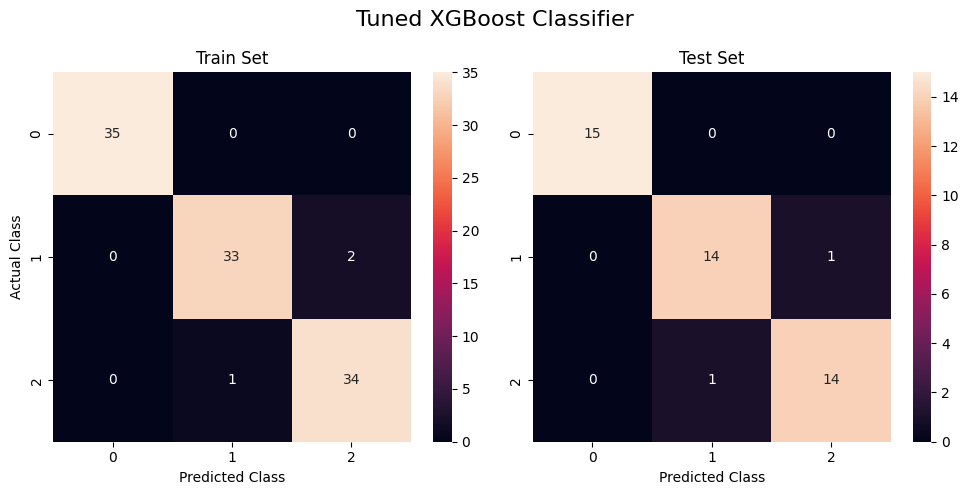

In [228]:
#After some manual hit and trial around the hyperparams given by RandomGridSearch
xgb_clf = xgboost.XGBClassifier(n_estimators =20, min_child_weight = 2, max_depth = 1, gamma = 0.5, eta = 0.4, colsample_bytree = 1)
model_perf(xgb_clf, "Tuned XGBoost Classifier")

In [241]:
# # Save the model for future use
# with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf.pkl", mode = 'wb') as file:
#   pickle.dump(xgb_clf, file)